# Investigate a Dataset - Titanic Dataset

## Introduction
This report is aiming at analyzing the titanic dataset that are provided on [Kaggle](https://www.kaggle.com/c/titanic/data). This report will look into a number of feature of the passengers to see what are the factors that might be relevant to the survival of passengers.

## Table of Content
There are a number of parts in this report
1. Data Wraggling
2. Correlation Analysis - Analysing correlations between a number of the features from the data as this might have an effect on our conclusions at the end
3. Validation on some well-known rumours
    * Children and elderly are more likely to survived as people tend to take care of them
    * Female are more likely to survived as people tend to let female passengers board the rescue boats first (as illustrated in the Titanic movie)
    * Rich people have a higher surivial rate due to a number of reasons, including priority of boarding rescue boat, bribing the crew and other unknowen reasons
4. Conclusions

## Data Wraggling
Before doing any analysis, we will first need to import all the necessary python packages and the data

In [33]:
# import all necessary packages and functions.
import csv
import numpy as np
import pandas as pd
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt

# read in the data by pandas
passengers_data = pd.read_csv('titanic-data.csv')
display(passengers_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


After taking a glimpse of the data, there are a few fields looks pretty meaningless (i.e. `PassengerId`, `Name`, `Ticket`) in the following analysis, so we will first remove them.

In [34]:
passengers_data.drop('PassengerId', axis=1, inplace=True)
passengers_data.drop('Name', axis=1, inplace=True)
passengers_data.drop('Ticket', axis=1, inplace=True)
display(passengers_data.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


For easier analysis, we would want to setup the `Survived`, `Pclass` and `Sex` fields as categorical data

In [53]:
for col in ['Survived', 'Pclass', 'Sex']:
    passengers_data[col] = passengers_data[col].astype('category')

## Correlation Analysis
In this section, we will make use of correlation matrix to see if there are any correlation between features.

In [54]:
passengers_data.corr()

,Age,SibSp,Parch,Fare
Age,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.308247,1.000000,0.414838,0.159651
Parch,-0.189119,0.414838,1.000000,0.216225
Fare,0.096067,0.159651,0.216225,1.000000


In general, we will an |correlation| < 0.3 as weak correlation(which we usually consider as no significant correlation. For 0.3 < |correlation| < 0.7, it is considered as moderate correlaton. From what we found, there seemed to be a moderate correlation between `# of siblings / spouses aboard the Titanic` and `# of parents / children aboard the Titanic` which can be reasonably explained by the case of family trips.

## Validation on some well-known rumours
In this part, we will look into three famous rumours or guesses people made on the Titanic tragedy.

### Children and elderly are more likely to survived as people tend to take care of them
To investigate on this issue, we will first needed to define `Children` as age < 12 and `Elderly` as age > 60. First, we will look at how many children and elderly are onboard.

(array([  39.,   64.,  104.,   46.,   30.,    6.,    1.,    0.,    0.]),
 array([  0,  12,  24,  36,  48,  60,  72,  84,  96, 104]),
 <a list of 9 Patch objects>)

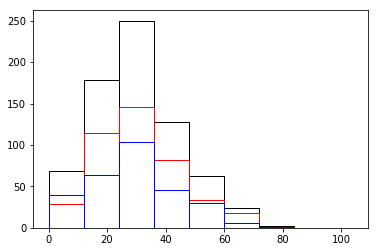

In [78]:
# filter out passengers by survival
survived = passengers_data[passengers_data['Survived']==1]
dead = passengers_data[passengers_data['Survived']==0]

# plotting the age distribution of all, survived and dead passengers on the same graph
plt.figure(1)
plt.hist(passengers_data.Age.dropna(), bins=[0,12,24,36,48,60,72,84,96,104], edgecolor='black', fill=False, stacked=False)
plt.hist(dead.Age.dropna(), bins=[0,12,24,36,48,60,72,84,96,104], edgecolor = "red", stacked=True, fill=False)
plt.hist(survived.Age.dropna(), bins=[0,12,24,36,48,60,72,84,96,104], edgecolor = "blue", stacked=True, fill=False)


From the histogram, we can see that among all ages groups except children with age under 12, are having a lower survival rate than death rate. So the myth that both children and elderly are having a higher survival rate is only partially correct.

By assuming that people does give priority to leave Titanic for children and elderly, we can attribute the low surivial rate of elderly by bad health conditions and less likely to withstand the extreme body requirements to survive in the freezing weather.

### Female are more likely to survived as people tend to let female passengers board the rescue boats first (as illustrated in the Titanic movie)

To investigate this issue, we can do a similar analysis as the previous rumour, except we are plotting the geneder distribution instead

([<matplotlib.axis.XTick at 0x114a3cfd0>,
 <a list of 2 Text xticklabel objects>)

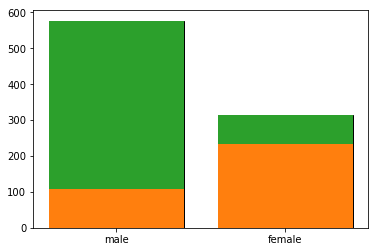

In [86]:
# plotting the gender distribution of survived and dead passengers on the same graph
plt.figure(2)

# for survived passengers
survived_counts = Counter(survived.Sex)
survived_frequencies = survived_counts.values()
plt.bar(bar_x_locations, survived_frequencies, align = 'center')

# for dead passengers
dead_counts = Counter(dead.Sex)
dead_frequencies = dead_counts.values()
plt.bar(bar_x_locations, dead_frequencies, bottom=survived_frequencies, align = 'center')

# adding label for x axis
plt.xticks(bar_x_locations, x_labels)


Obviously, female is having a much higher percentage of survival comparing to male, as shown in the figure. To have a more concrete comparison, we will be calculating the actual survival rate as below:

In [101]:
counts = Counter(passengers_data.Sex)
survival_counts = Counter(survived.Sex)

male_survival_rate = float(survival_counts['male'])/counts['male']
female_survival_rate = float(survival_counts['female'])/counts['female']

print 'Male Survival Rate: {:.1%}'.format(male_survival_rate)
print 'Female Survival Rate: {:.1%}'.format(female_survival_rate)

Male Survival Rate: 18.9%
Female Survival Rate: 74.2%


Putting our findings in a numerical way, female is having a 74.2% of survival rate while male got a survival rate of 18.9% only. While we cannot conclude if this is really due to the female priority for rescue boat, but at least we can be sure that there was a correlation between gender and survival in the Titanic incident.

### Rich people have a higher surivial rate due to a number of reasons

(array([ 216.,    0.,    0.,    0.,    0.,  184.,    0.,    0.,    0.,  491.]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <a list of 10 Patch objects>)

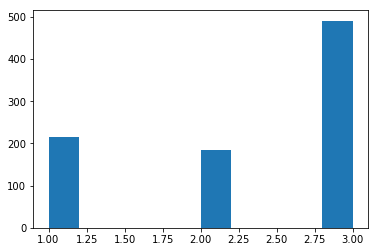

In [39]:
# An inituition of passengers distributions
plt.hist(passengers_data.Pclass)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


(array([ 2.,  2.,  2.,  2.,  1.,  3.,  2.]),
 array([1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 7 Patch objects>)

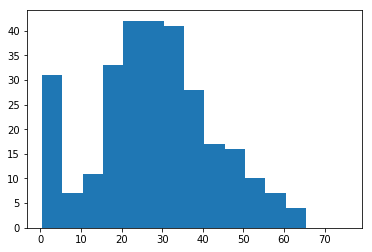

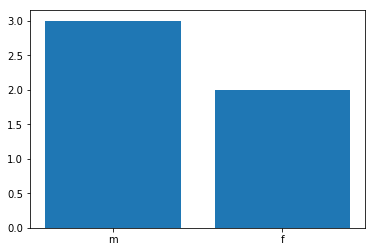

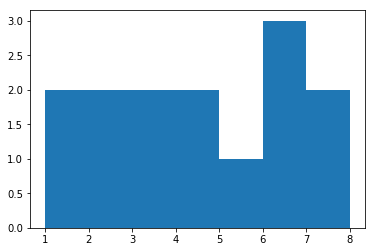

In [9]:
# we might also want to know the survival rate of each class

from collections import Counter

survived = passengers_data[passengers_data['Survived']==1]
display(survived.head())

plt.figure(5)
data = ['m', 'f', 'm', 'f', 'm']
counts = Counter(data)
frequencies = counts.values()
x_labels = counts.keys()
bar_x_locations = np.arange(len(frequencies))

plt.bar(bar_x_locations, frequencies, align = 'center')
plt.xticks(bar_x_locations, x_labels)

plt.figure(1)
bins = np.arange(min(survived.Age.dropna()), max(survived.Age.dropna()), 5)
plt.hist(survived.Age.dropna(), bins=bins)

data = [1,2,3,4,5,6,6,6,7,8,1,2,3,4]

plt.figure(7)
bin_width = 1
bins = np.arange(min(data), max(data) + bin_width, bin_width)
plt.hist(data, bins=bins)




In [10]:
passengers_data.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408
